In [9]:
import numpy as np 
import pandas as pd
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
import pickle

In [10]:
data = pd.read_excel('./annotations_binary.xlsx')

In [11]:
data.Sentence = data.Sentence.astype(str)

In [13]:
data.Sentiment.value_counts()

positive    193919
neutral     165327
negative    136238
Name: Sentiment, dtype: int64

In [14]:
#taking balanced classes
num_of_categories = 136238
shuffled = data.reindex(np.random.permutation(data.index))
positive = shuffled[shuffled['Sentiment'] == 'positive'][:num_of_categories]
neutral = shuffled[shuffled['Sentiment'] == 'neutral'][:num_of_categories]
negative = shuffled[shuffled['Sentiment'] == 'negative'][:num_of_categories]
concated = pd.concat([positive,neutral,negative], ignore_index=True)

#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))
concated['LABEL'] = 0

In [15]:
#One-hot encode the labels
concated.loc[concated['Sentiment'] == 'positive', 'LABEL'] = 0
concated.loc[concated['Sentiment'] == 'neutral', 'LABEL'] = 1
concated.loc[concated['Sentiment'] == 'negative', 'LABEL'] = 2
print(concated['LABEL'][:30])
labels = to_categorical(concated['LABEL'], num_classes=3)
print(labels[:30])
if 'Sentiment' in concated.keys():
    concated.drop(['Sentiment'], axis=1)
'''
 [1. 0. 0.] positive
 [0. 1. 0.] neutral
 [0. 0. 1.] negative
 '''

227150    1
265641    1
59483     0
281767    2
59772     0
248362    1
8003      0
399892    2
126507    0
64631     0
136951    1
28534     0
76328     0
236275    1
39573     0
323491    2
294752    2
173857    1
322342    2
385514    2
39577     0
306486    2
22255     0
171214    1
104143    0
168243    1
118595    0
254888    1
387684    2
223141    1
Name: LABEL, dtype: int64
[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


'\n [1. 0. 0.] positive\n [0. 1. 0.] neutral\n [0. 0. 1.] negative\n '

In [16]:
n_most_common_words = 10000
max_len = 200
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(concated['Sentence'].values)
sequences = tokenizer.texts_to_sequences(concated['Sentence'].values)
word_index = tokenizer.word_index

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 143014 unique tokens.


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.3, random_state=42)

In [18]:
epochs = 10
emb_dim = 128
batch_size = 256
labels[:2]

array([[0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [13]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])
model.save('lstm_model.h5')

((286099, 200), (286099, 3), (122615, 200), (122615, 3))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          1280000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 1,329,603
Trainable params: 1,329,603
Non-trainable params: 0
_________________________________________________________________
None
Train on 228879 samples, validate on 57220 samples
Epoch 1/10
228879/228879 [==============================] - 992s 4ms/step - loss: 0.7839 - acc: 0.6379 - val_loss: 0.4040 - val_acc: 0.8605
Epoch 2/10


In [14]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

122615/122615 [==============================] - 147s 1ms/step
Test set
  Loss: 0.261
  Accuracy: 0.926


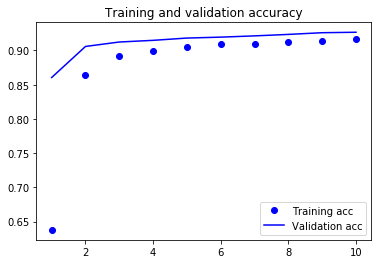

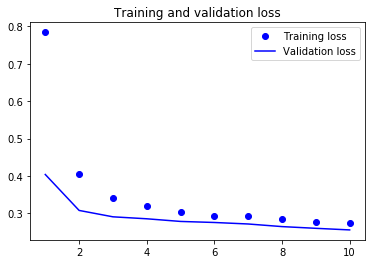

In [17]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
#Sample sentences taken from online news articles

txt = ["He praised Modi, and even expressed the wish that he should get a second term."] 
txt2 = ["In a veiled attack on Prime Minister Narendra Modi, the Shiv Sena on Monday said no political “wave” had ever solved the Kashmir issue or stopped the killing of soldiers."]
seq = tokenizer.texts_to_sequences(txt)
seq2 = tokenizer.texts_to_sequences(txt2)
padded = pad_sequences(seq, maxlen=max_len)
padded2 = pad_sequences(seq2, maxlen=max_len)
pred = model.predict(padded)
pred2 = model.predict(padded2)
labels = ['positive', 'neutral', 'negative']
print("Sentence: \n", txt)
print("Predicted Class: ", labels[np.argmax(pred)])
print()
print("Labels in decreasing order of most suitable category: ")
print("Positive: ", pred[0][0]*100,"%")
print("Neutral: ", pred[0][1]*100,"%")
print("Negative: ", pred[0][2]*100,"%")
print()
print()

print("Sentence: \n", txt2)
print("Predicted Class: ", labels[np.argmax(pred2)])
print()
print("Labels in decreasing order of most suitable category: ")
print("Negative: ", pred2[0][2]*100,"%")
print("Positive: ", pred2[0][0]*100,"%")
print("Neutral: ", pred2[0][1]*100,"%")

Sentence: 
 ['He praised Modi, and even expressed the wish that he should get a second term.']
Predicted Class:  positive

Labels in decreasing order of most suitable category: 
Positive:  99.5484709739685 %
Neutral:  0.28680115938186646 %
Negative:  0.1647236873395741 %


Sentence: 
 ['In a veiled attack on Prime Minister Narendra Modi, the Shiv Sena on Monday said no political “wave” had ever solved the Kashmir issue or stopped the killing of soldiers.']
Predicted Class:  negative

Labels in decreasing order of most suitable category: 
Negative:  99.82505440711975 %
Positive:  0.0725266057997942 %
Neutral:  0.10242180433124304 %
